# Common grid bias-adjustment quality control

Quality control the bias-adjusted data!

In [2]:
# parameters cell
working_dir = "/import/beegfs/CMIP6/kmredilla"
sim_dir = "/import/beegfs/CMIP6/kmredilla/cmip6_regridding/regrid"
ref_dir = "/import/beegfs/CMIP6/arctic-cmip6/era5/daily_regrid"

In [3]:
from datetime import datetime
from itertools import product
from pathlib import Path
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from dask.distributed import Client
from config import output_dir_name, ref_tmp_fn, cmip6_tmp_fn
from bias_adjust import generate_adjusted_filepaths, generate_cmip6_fp
from slurm import get_directories
from luts import sim_ref_var_lu


working_dir = Path(working_dir)
sim_dir = Path(sim_dir)
ref_dir = Path(ref_dir)

output_dir, adj_dir = get_directories(working_dir, output_dir_name)

## Verify long term average summaries

Compare the averaged day-of-year values between reference data, unadjusted model data, and adjusted model data.

In [4]:
# adjusted filepaths
model = "GFDL-ESM4"
scenario = "ssp585"
var_id = "dtr"

adj_fps = list(adj_dir.joinpath(model, scenario, "day", var_id).glob("*.nc"))

# reference filepaths

We only have 7 years that were adjusted which overlap the reference period, but that should be sufficient. 

In [5]:
sim_ref_start_year = 2015
sim_ref_end_year = 2022
sim_ref_years = list(range(sim_ref_start_year, sim_ref_end_year + 1))
ref_var_id = sim_ref_var_lu[var_id]
ref_fps = [
    ref_dir.joinpath(var_id, ref_tmp_fn.format(ref_var_id=ref_var_id, year=year))
    for year in sim_ref_years
]


sim_ref_years = list(range(sim_ref_start_year, sim_ref_end_year + 1))
sim_ref_fps = [
    generate_cmip6_fp(sim_dir, model, scenario, var_id, year) for year in sim_ref_years
]

In [6]:
client = Client(n_workers=4, memory_limit="4GB")

In [7]:
adj_ds = xr.open_mfdataset(adj_fps)
ref_ds = xr.open_mfdataset(ref_fps)
sim_ref_ds = xr.open_mfdataset(sim_ref_fps)

In [8]:
sel_di = {"lon": -147, "lat": 65}

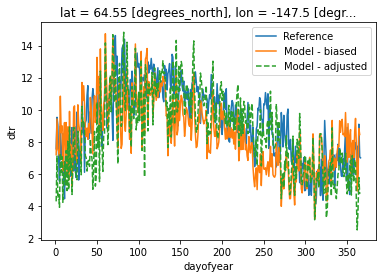

In [9]:
ref_ds[ref_var_id].sel(sel_di, method="nearest").groupby("time.dayofyear").mean().plot(
    label="Reference"
)
sim_ref_ds[var_id].sel(sel_di, method="nearest").groupby("time.dayofyear").mean().plot(
    label="Model - biased"
)
adj_ds[var_id].sel(time=slice(str(sim_ref_start_year), str(sim_ref_end_year))).sel(
    sel_di, method="nearest"
).groupby("time.dayofyear").mean().plot(label="Model - adjusted", linestyle="--")

plt.legend()